In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/edsa-movie-recommendation-2022/sample_submission.csv
/kaggle/input/edsa-movie-recommendation-2022/movies.csv
/kaggle/input/edsa-movie-recommendation-2022/imdb_data.csv
/kaggle/input/edsa-movie-recommendation-2022/genome_tags.csv
/kaggle/input/edsa-movie-recommendation-2022/genome_scores.csv
/kaggle/input/edsa-movie-recommendation-2022/train.csv
/kaggle/input/edsa-movie-recommendation-2022/test.csv
/kaggle/input/edsa-movie-recommendation-2022/tags.csv
/kaggle/input/edsa-movie-recommendation-2022/links.csv



# Import libraries and datasets

In [2]:
# Data manipulation

import re

# Ignore warnings 
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Data visualization
import matplotlib
import seaborn as sns 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS 

# Style
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
sns.set(style="whitegrid")
sns.set_style("dark")

# Building recommender systems
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import SVD
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Loading data# Datasets

In [3]:
train = pd.read_csv("/kaggle/input/edsa-movie-recommendation-2022/train.csv")
test = pd.read_csv("../input/edsa-movie-recommendation-2022/test.csv")
tags = pd.read_csv("../input/edsa-movie-recommendation-2022/tags.csv")
movies = pd.read_csv("../input/edsa-movie-recommendation-2022/movies.csv")
links = pd.read_csv("../input/edsa-movie-recommendation-2022/links.csv")
imdb_data = pd.read_csv("../input/edsa-movie-recommendation-2022/imdb_data.csv")
genome_tags = pd.read_csv("../input/edsa-movie-recommendation-2022/genome_tags.csv")
genome_scores = pd.read_csv("../input/edsa-movie-recommendation-2022/genome_scores.csv")

# A glance through the raw data

In [4]:
display(movies.head())
display(imdb_data.head())
display(tags.head())
display(train.head())
display(test.head())
display(genome_scores.head())
display(genome_tags.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


## Checking counts of useful informations

In [5]:
# Count the number of unique entries for features of interest
unique_movies = len(movies['movieId'].unique().tolist())
unique_tags = len(tags['tag'].unique().tolist())
unique_users = len(train['userId'].unique().tolist())
unique_directors = len(imdb_data['director'].unique().tolist())
unique_actors = len(imdb_data['title_cast'].unique().tolist())

# Create a dataframe to store the number of unique entries for features of interest
unique = pd.DataFrame({"movies": [unique_movies],
                       "tags" : [unique_tags],
                       "users": [unique_users],
                       "directors" : [unique_directors],
                       "actors" : [unique_actors]}, index=['unique_entries'])

print('number of unique entries for features of interest')
display(unique)

# Determine and display the min and max ratings received
min_rating = train.rating.min()
max_rating = train.rating.max()
print('Lowest rating: {}'.format(min_rating))
print('Highest rating: {}'.format(max_rating))

#shape of train and test data
shape_train = train.shape
shape_test = test.shape
print('shape of train data: {}'.format(shape_train))
print('shape of test data: {}'.format(shape_test))


number of unique entries for features of interest


,movies,tags,users,directors,actors
unique_entries,62423,73051,162541,11787,17144


Lowest rating: 0.5
Highest rating: 5.0
shape of train data: (10000038, 4)
shape of test data: (5000019, 2)


### Deductions from raw data
- The database contains 62423 Unique movies, with 73051 tags
- movies are rated between 0.5 to 5 points
- there are over 10 milloin rows and 4 colums in the train data
- there are over 5 millon row and 2 columns in the test data and 

# Data Engineering/Cleaning

### Creating new dataframe of all in one usefull features¶

In [6]:
df = imdb_data[['movieId','title_cast','director', 'plot_keywords']]
df = df.merge(movies[['movieId', 'genres', 'title']], on='movieId', how='inner')
df.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,toy|rivalry|cowboy|cgi animation,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995)
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,board game|adventurer|fight|game,Adventure|Children|Fantasy,Jumanji (1995)
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,boat|lake|neighbor|rivalry,Comedy|Romance,Grumpier Old Men (1995)
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,black american|husband wife relationship|betra...,Comedy|Drama|Romance,Waiting to Exhale (1995)
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion,Comedy,Father of the Bride Part II (1995)


### Cleaning Data

In [7]:
# Convert data types to strings for string handling
df['title_cast'] = df.title_cast.fillna("").astype(str)
df['plot_keywords'] = df.plot_keywords.fillna("").astype(str)
df['genres'] = df.genres.fillna("").astype(str)
df['director'] = df.director.fillna("").astype(str)

# Removing spaces between names
df['director'] = df['director'].apply(lambda x: "".join(x.lower() for x in x.split()))
df['title_cast'] = df['title_cast'].apply(lambda x: "".join(x.lower() for x in x.split()))

# Discarding the pipes between the actors' full names and getting only the first four names
df['title_cast'] = df['title_cast'].map(lambda x: x.split('|')[:4])

# Discarding the pipes between the plot keywords' and getting only the first five words
df['plot_keywords'] = df['plot_keywords'].map(lambda x: x.split('|')[:5])
df['plot_keywords'] = df['plot_keywords'].apply(lambda x: " ".join(x))

# Discarding the pipes between the genres 
df['genres'] = df['genres'].map(lambda x: x.lower().split('|'))
df['genres'] = df['genres'].apply(lambda x: " ".join(x))

df.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,"[tomhanks, timallen, donrickles, jimvarney]",johnlasseter,toy rivalry cowboy cgi animation,adventure animation children comedy fantasy,Toy Story (1995)
1,2,"[robinwilliams, jonathanhyde, kirstendunst, br...",jonathanhensleigh,board game adventurer fight game,adventure children fantasy,Jumanji (1995)
2,3,"[waltermatthau, jacklemmon, sophialoren, ann-m...",markstevenjohnson,boat lake neighbor rivalry,comedy romance,Grumpier Old Men (1995)
3,4,"[whitneyhouston, angelabassett, lorettadevine,...",terrymcmillan,black american husband wife relationship betra...,comedy drama romance,Waiting to Exhale (1995)
4,5,"[stevemartin, dianekeaton, martinshort, kimber...",alberthackett,fatherhood doberman dog mansion,comedy,Father of the Bride Part II (1995)


# Exploratory Data Analysis


# Genre

In [8]:
#set of genres
all_genres = set(','.join([genres.replace('|',',').lower() for genres in movies.genres]).split(','))
#all_genres

In [9]:
# dictionary of genres and the corresponding counts
dict_count={}
for genre in all_genres:
    dict_count[genre] = ','.join([genres.replace('|',',').lower() for genres in movies.genres]).count(genre)
#dict_count
len(dict_count)

20

In [10]:
# sorting the genre counts in descending order
sorted_dict = sorted(dict_count.items(), key=lambda x: x[-1],reverse=True)
genre, frequency = zip(*sorted_dict)
sorted_dict

[('drama', 25606),
 ('comedy', 16870),
 ('thriller', 8654),
 ('romance', 7719),
 ('action', 7348),
 ('horror', 5989),
 ('documentary', 5605),
 ('crime', 5319),
 ('(no genres listed)', 5062),
 ('adventure', 4145),
 ('sci-fi', 3595),
 ('children', 2935),
 ('animation', 2929),
 ('mystery', 2925),
 ('fantasy', 2731),
 ('war', 1874),
 ('western', 1399),
 ('musical', 1054),
 ('film-noir', 353),
 ('imax', 195)]

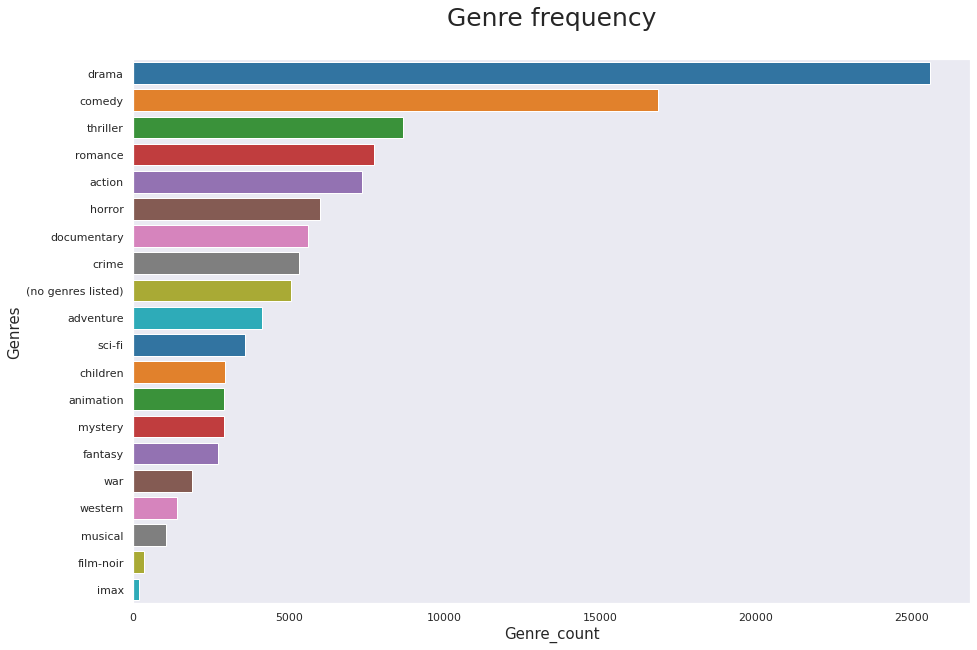

In [11]:
 # Create bar plot 
fig = plt.figure(4, figsize=(15,10))
sns.barplot(x=list(frequency), y= list(genre), palette='tab10')
plt.title('Genre frequency\n',fontsize=25)
plt.xlabel('Genre_count', fontsize=15)
plt.ylabel('Genres', fontsize=15)
    
plt.show()
    

## Observations
- There are 19 unique genres in the data set
- 5062 movies have no records for genre

# Ratings

What are the ratings availaible in the dataset?

In [12]:
# Merge train with movies to join movie titles and ratings 
ratings = train.merge(movies, on='movieId', how='inner')
ratings.drop('timestamp', axis=1, inplace=True)
ratings.head()

,userId,movieId,rating,title,genres
0,5163,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller


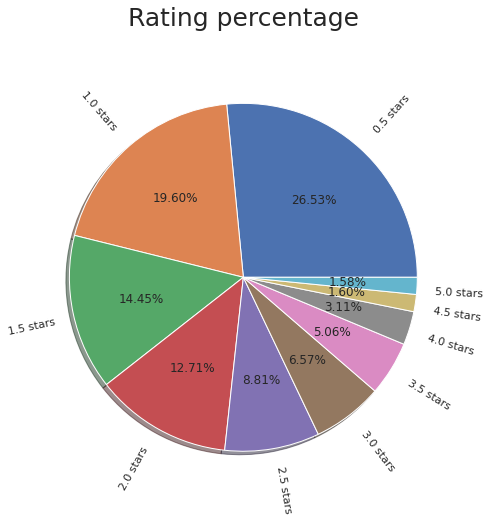

In [13]:
# Count how many ratings are in each category (1 star, 2 star, ect)
grouped = pd.DataFrame(ratings.groupby(['rating'])['title'].count())
grouped.rename(columns={'title':'rating_count'}, inplace=True)


grouped.reset_index(inplace=True)
grouped["rating"] = [str(i)+" stars" for i in grouped["rating"]]
grouped["rating_count"] = sorted(grouped["rating_count"], reverse=True)
#palette_color = sns.color_palette('bright')
 # Create bar plot 

fig = plt.figure(4, figsize=(8,8))
plt.pie(grouped["rating_count"].to_list(), labels= grouped["rating"].to_list(), autopct='%.2f%%', shadow=True, rotatelabels=True)
plt.title('Rating percentage\n',fontsize=25)

plt.show()
    

# Deductions
- only about 18% 0f the total movies have rating between 3 stars and 5 stars
- 60 % of the movies have ratings between 0 and 1.5 stars
- 21 % of the data have between 2 and 3 star ratings

# Greatest hits: most popular movies
Popularity will be determined as the product of the average rating and the number of ratings a film has received.

In [14]:
#average rating of a movie
avg_ratings = round(ratings.groupby(["title"])[["rating"]].mean(), 2)
avg_ratings['rating_counts'] = ratings.groupby(['title'])['rating'].count().to_list()
avg_ratings['popularity'] = avg_ratings["rating_counts"]*avg_ratings["rating"]
popularity_ratings = avg_ratings.sort_values(by="popularity", ascending=False)

# first ten most popular film
popularity_ratings.head(10)

,rating,rating_counts,popularity
title,,,
"Shawshank Redemption, The (1994)",4.42,32831,145113.02
Pulp Fiction (1994),4.20,31697,133127.40
Forrest Gump (1994),4.05,32383,131151.15
"Silence of the Lambs, The (1991)",4.14,29444,121898.16
"Matrix, The (1999)",4.15,29014,120408.10
Star Wars: Episode IV - A New Hope (1977),4.11,27560,113271.60
Schindler's List (1993),4.25,24004,102017.00
Fight Club (1999),4.23,23536,99557.28
Star Wars: Episode V - The Empire Strikes Back (1980),4.15,22956,95267.40


# Deductions
- the most popular film in the database is "Shawshank Redemption, The (1994)" rated by 32831 users with an average rating of 4.42
* We see some really good movies like the Martrix, Star Wars and the Lord of the Rings, Braveheart in the top 15. 
* The above list supports our point that good movies normally receive both more and higher ratings
* An interesting thing to note is that all the movies in the top 10 are older, with none of the movies more recent than 1999.
* This just could be because these movies have been around longer and have been rated more as a result

## How was the most popular film rated by users?

- this can be obtained from a piechart

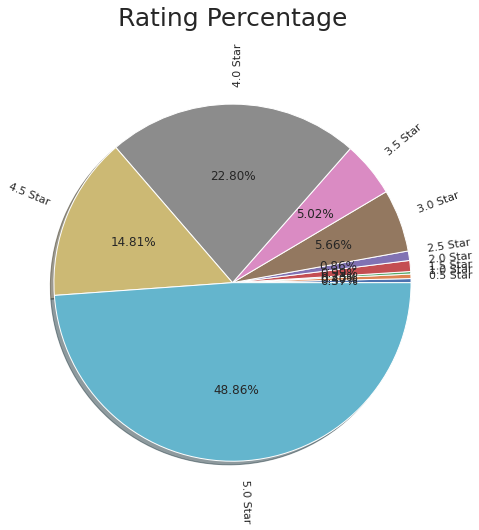

In [15]:
# The unique ratings for "Shawshank Redemption, The (1994)"
Shawshank_r=ratings[ratings["title"]=="Shawshank Redemption, The (1994)"]
Shawshank_r_gr=pd.DataFrame(Shawshank_r.groupby(["rating"])["rating"].count())
Shawshank_r_gr.rename(columns={"rating" : "rating_counts"}, inplace=True)
Shawshank_r_gr=Shawshank_r_gr.reset_index()
Shawshank_r_gr["rating"] = [str(i)+" Star" for i in Shawshank_r_gr["rating"]]

#create piechart
fig = plt.figure(4, figsize=(8,10))
plt.pie(Shawshank_r_gr["rating_counts"].to_list(), labels= Shawshank_r_gr["rating"], autopct='%.2f%%', shadow=True, rotatelabels=True)
plt.title('Rating Percentage\n',fontsize=25)

plt.show()


# deductions
- over 86% of users who rated for the film "Shawshank Redemption, The (1994)" gave a rating between 4 stars and 5 start, of which 48.86% of the users rated the film with 5 stars
- 

# keywords

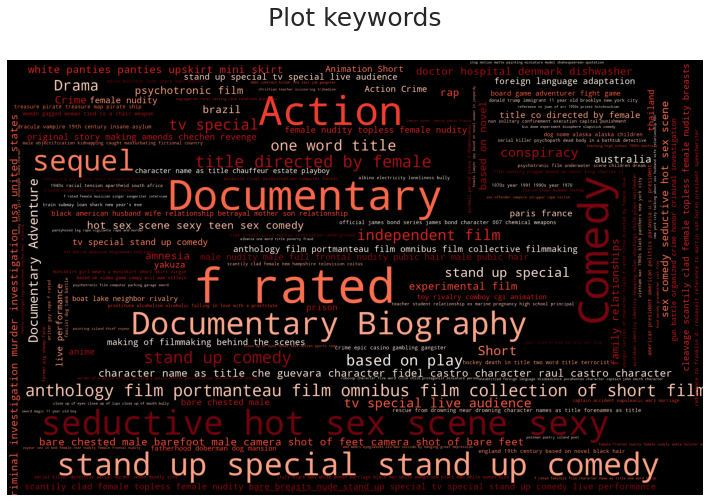

In [16]:
def wordcloud_generator(df, column):  
    """
    This function extracts all the unique keywords in a column
    and counts the number of times each keyword occurs in the column
    while ignoring words that are not meaningful.
    these keywords are then used to generate a word cloud 
    
    Input: df
           datatype: DataFrame
           column
           datatype: str
           
    Output: wordcloud
            Datatype: None
            
    """    
    keyword_counts = {}
    keyword_pair = []
    words = dict()
    
    # list of words that should be ignored
    ignore = ['nan', ' nan', 'nan ', 'seefullsummary', ' seefullsummary', 'seefullsummary ']
    
    # Extract the unique keywords 
    for keyword in [keyword for keyword in df[column] if keyword not in ignore]:
        if keyword in keyword_counts.keys():
            keyword_counts[keyword] += 1
        else:
            keyword_counts[keyword] = 1
     
    # Pair the keywords with their frequencies
    for word,word_freq in keyword_counts.items():
        keyword_pair.append((word,word_freq))
       
    # Sort the keywords accprding to their frequencies
    keyword_pair.sort(key = lambda x: x[1],reverse=True)
    
    # Make it wordcloud-ready
    for s in keyword_pair:
        words[s[0]] = s[1]
        
    # Create a wordcloud using the top 2000 keywords
    wordcloud = WordCloud(width=800, 
                          height=500, 
                          background_color='black', 
                          max_words=2000,
                          max_font_size=110,
                          scale=3,
                          random_state=0,
                          colormap='Reds').generate_from_frequencies(words)

    return wordcloud 

# Plot wordcloud
plot_keywords = wordcloud_generator(df, 'plot_keywords')
f = plt.figure(figsize=(20, 8)) 
plt.imshow(plot_keywords) 
plt.axis('off') 
plt.title('Plot keywords\n', fontsize=25)
plt.show()

## Directors
A film director controls a film's artistic and dramatic aspects and visualizes the screenplay while guiding the technical crew and actors in the fulfilment of that vision. The director has a key role in choosing the cast members, production design and all the creative aspects of filmmaking.

Let's have a closer look at the directors that appear frequently in our dataset. They must be doing something right.

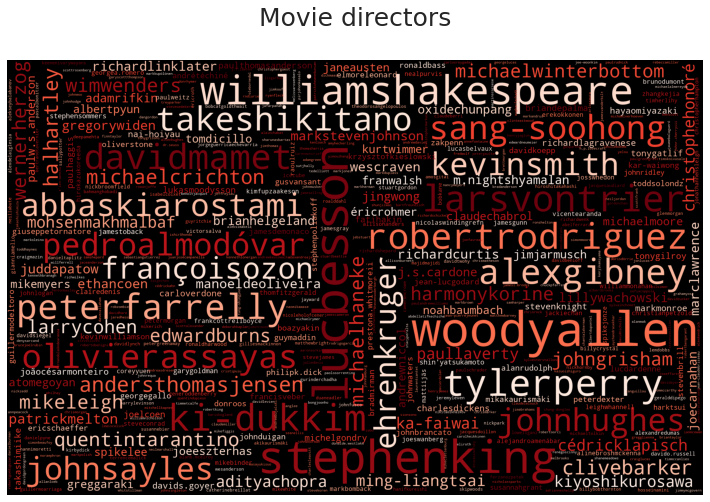

In [17]:
# Generate a WordCloud using the movie directors  
directors = wordcloud_generator(df, 'director')

# Plot the WordCloud 
f = plt.figure(figsize=(20, 8)) 
plt.imshow(directors) 
plt.axis('off') 
plt.title('Movie directors\n', fontsize=25)
plt.show()

## Content based Recomender System


**Idea: If you like an item then you will also like a “similar” item**

Content based recommender systems are based on the similarity of the items being recommended. It generally works well when its easy to determine the context/properties of each item. For instance when we are recommending the same kind of item like a movie recommendation or song recommendation.

In this recommender system the content of the movie (genre, keywords, cast, directors, tags, etc) will be used to find its similarity with other movies. The movies that are most likely to be similar are then recommended.



### Creating the corpus for each movie
We will be using the cast, director, plot keywords and genre as the metadata for our content based recommender system. These columns will be combined to form the corpus for each film which will then be used to determine the similarity between films.

In [18]:
df2=df.copy()
df2["title_cast"]= df2["title_cast"].str.join(' ')

# Creating an empty column and list to store the corpus for each movie
df2['corpus'] = ''
corpus = []

# List of the columns we want to use to create our corpus 
columns = ['title_cast', 'director', 'plot_keywords', 'genres']

# For each movie, combine the contents of the selected columns to form it's unique corpus 
for i in range(0, len(df2['movieId'])):
    words = ''
    for col in columns:
        words = words + df2.loc[i][col] + " "        
    corpus.append(words)

# Add the corpus information for each movie to the dataframe 
df2['corpus'] = corpus
df2.set_index('movieId', inplace=True)

# Drop the columns we don't need anymore to preserve memory
df2.drop(columns=['title_cast', 'director', 'plot_keywords', 'genres'], inplace=True)


### Count matrix
Our corpus will be converted into a bag of words using the count vectorizer. 


In [19]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df2['corpus'])

### Cosine similarity matrix

Similarity is calculated as the cosine of the angle between the 2 vectors of the item vectors of A and B. The closer the vectors, the smaller the angle and larger the cosine similarity.


In [20]:
cos_sim = cosine_similarity(count_matrix, count_matrix)
print(cos_sim.shape)
cos_sim

(24866, 24866)


array([[1.        , 0.18786729, 0.14002801, ..., 0.06063391, 0.        ,
        0.14002801],
       [0.18786729, 1.        , 0.        , ..., 0.12909944, 0.        ,
        0.1490712 ],
       [0.14002801, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.06063391, 0.12909944, 0.        , ..., 1.        , 0.        ,
        0.07216878],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.14002801, 0.1490712 , 0.        , ..., 0.07216878, 0.        ,
        1.        ]])

### Top-N Recommendations
With our content similarity matrix computed, we're now ready to make some recommendations. We will begin by generating a top-N list of movies similar to one which we prompt the system with.

In [21]:
#making recomendations
def get_topN_recommendations(title, n=10):
    """
    This function gets the top n recomended movies based on the 
    title of the movie input by the user 
    
    Input: title
           Datatype: str
           
           n (default = 10)
           Datatype: int
    """ 
    

In [22]:
#Extract movie titles
def sugest_movies(title, n):
    """
    This function gets the top n recomended movies based on the 
    title of the movie input by the user 
    
    Input: title
           Datatype: str
           
           n (default = 10)
           Datatype: int
    """ 
    #creating a list of all the movies
    df1 = df2.copy
    list_of_title = df1["title"].tolist()
    
    #finding close match for the given title
    

In [23]:
def get_topN_recommendations(title, n=10):
    """
    This function gets the top n recomended movies based on the 
    title of the movie input by the user 
    
    Input: title
           Datatype: str
           
           n (default = 10)
           Datatype: int
    """ 
    # Create a a copy of the input dataframe where the index has been reset
    df1 = df2.reset_index()
    
    # Extract the movie titles
    titles = df1['title']
    indices = pd.Series(df1.index, index=df['title'])
    idx = indices[title]
    
    # Get the similarity scores of the top n movies most similar to the user input
    sim_scores = list(enumerate(cos_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n]
    
    # Exctract the titles of the top n most similar movies  
    movie_indices = [i[0] for i in sim_scores]
    
    return titles.iloc[movie_indices]

get_topN_recommendations('Ice Age (2002)').head(10)

10648           Ice Age 2: The Meltdown (2006)
18129      Ice Age 4: Continental Drift (2012)
13437    Ice Age: Dawn of the Dinosaurs (2009)
16662                   Winnie the Pooh (2011)
23854     A Flintstones Christmas Carol (1994)
151                      Batman Forever (1995)
9591             Pooh's Heffalump Movie (2005)
4873         Bill & Ted's Bogus Journey (1991)
7038                          Peter Pan (2003)
Name: title, dtype: object

## Collaborative Based Filtering

### User-user collaborative based filtering

This method captures the underlying pattern of interests of like-minded users and uses the choices and preferences of similar users to suggest new items.


In [24]:
# Creating a small test dataframe to evaluate our models
tests = train.copy()
tests.drop(['timestamp'], axis=1, inplace=True)
tests = tests.head(10000)

# Creating the training data
reader = Reader(rating_scale=(0.5, 5))
test_data = Dataset.load_from_df(tests[['userId','movieId','rating']], reader)

# Compute similarities between users using cosine distance
sim_options = {"name": "cosine",
               "user_based": True}  

# Evaluate the model 
user = KNNWithMeans(sim_options=sim_options)
cv = cross_validate(user, test_data, cv=5, measures=['RMSE'], verbose=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1241  1.0944  1.1075  1.1256  1.0863  1.1076  0.0156  
Fit time          2.59    2.63    2.60    2.61    2.64    2.61    0.02    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    


### Item-item collaborative based filtering

To tackle the issues with user-based collaborative based techniques, item-based collaborative techniques analyze the user-item matrix and identify relationships between different items (Sarwar et al.,2001). The item-based recommendation system then makes recommendations based on the discovered linear relationships (similarities) amongst the items. This method is more stable compared to user based collaborative filtering because the average item has a lot more ratings than the average user. So an individual rating doesn’t impact as much.

In [25]:
# Compute similarities between items using cosine distance
sim_options = {"name": "cosine",
               "user_based": False}  

# Fit the KNNwithmeans algorithm to the training set
item_based = KNNWithMeans(sim_options=sim_options)

# Evaluate the model 
cv = cross_validate(item_based, test_data, cv=5, measures=['RMSE'], verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0904  1.0868  1.1118  1.0773  1.0654  1.0863  0.0154  
Fit time          0.48    0.48    0.49    0.49    0.50    0.49    0.01    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    


### Singular value decomposition (SVD)

In [26]:
# Evaluate the model 
svd = SVD(random_state=0)
cv = cross_validate(svd, test_data, cv=5, measures=['RMSE'], verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0413  1.0710  1.0466  1.0280  1.0303  1.0435  0.0154  
Fit time          0.95    0.95    0.95    0.95    0.95    0.95    0.00    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    


# Submission

In [27]:
# Train the model on the entire dataset 
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(train[['userId','movieId','rating']], reader)
trainingSet = data.build_full_trainset()
svd.fit(trainingSet)

# Make predictions using the trained model
pred = [svd.predict(test.userId[i],test.movieId[i]).est for i in test.index]
test['rating'] = pred

In [28]:
# Create the csv file for submission
test['Id'] = test['userId'].astype(str)+'_'+test['movieId'].astype(str)
test = test[['Id','rating']]
test.to_csv('svd_submission.csv', index=False)

In [29]:
test.head()

,Id,rating
0,1_2011,3.079354
1,1_4144,4.242573
2,1_5767,3.634281
3,1_6711,4.460075
4,1_7318,2.248208
